<a href="https://colab.research.google.com/github/leticiaainoan/ECG-Colaboraty/blob/main/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Importando as bibliotecas
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler 
import warnings
import matplotlib.pyplot as plt
import cv2
warnings.filterwarnings('ignore') #Para sumir com os avisos


In [ ]:
#importando dados de treinamento e de teste
ptb_abnormal = pd.read_csv('/content/drive/MyDrive/TCC/ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('/content/drive/MyDrive/TCC/ptbdb_normal.csv', header=None)


In [ ]:

ptb_abnormal.rename(columns={187:"Class"}, inplace=True)
ptb_normal.rename(columns={187:"Class"}, inplace=True)


In [ ]:

print (" Classe de treinamento dados do MIT: \n", mit_train["Class"].value_counts())
print ("\:Classe de teste dados do MIT: \n", mit_test["Class"].value_counts())

 Classe de treinamento dados do MIT: 
 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64
\:Classe de teste dados do MIT: 
 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: Class, dtype: int64


In [ ]:

MIT_Outcome = {0. : 'Normal',
               1. : 'Batimento supraventricular prematuro',
               2. : 'Contração ventricular prematura',
               3. : 'Fusão de batimento ventricular e normal',
               4. : 'Batida inclassificável'}

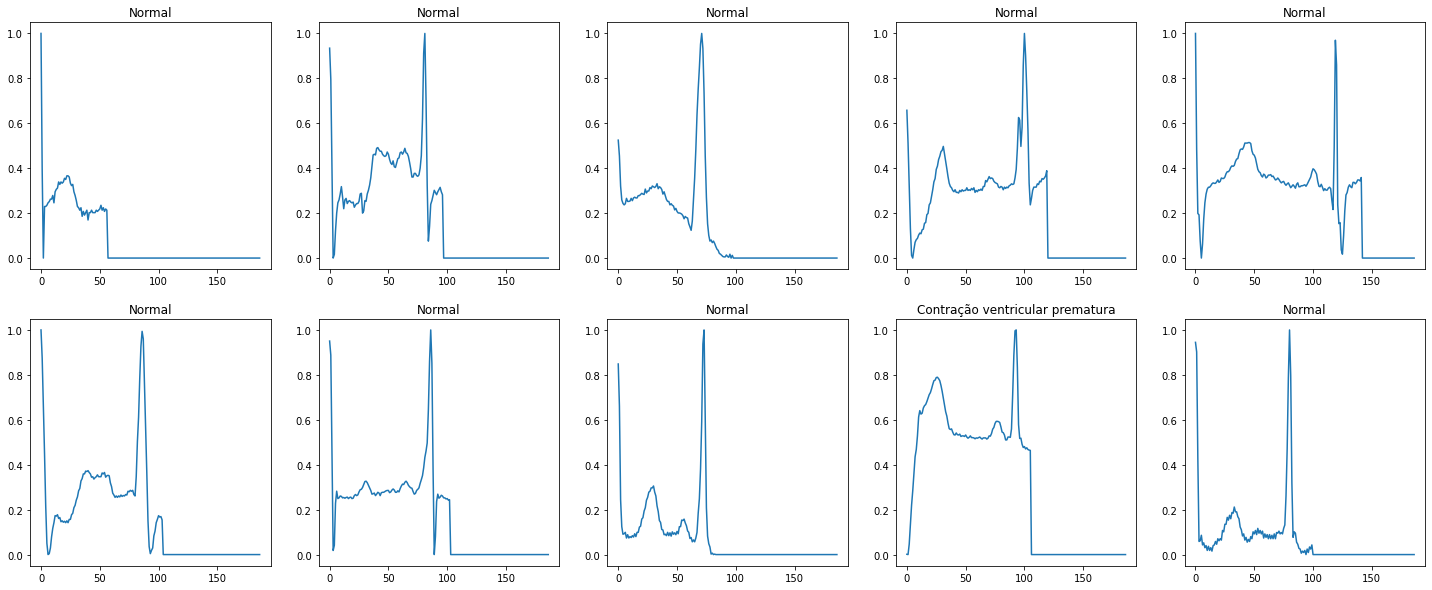

In [ ]:

plt.figure(figsize=(25,10))
np_count = np.linspace(0,186,187)
np_time = np.tile(np_count,(10,1))
rnd = np.random.randint(0,mit_train.shape[0],size=(10,))


for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    ax.plot(mit_train.iloc[rnd[i],np_time[i,:]])
    ax.set_title(MIT_Outcome[mit_train.loc[rnd[i],'Class']])

plt.show()

In [ ]:
!pip install -U tensorflow-addons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical




     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
# Since the MIT dataset already comes as a train set and test set, we just split 20% of the training set for validation
train_mit, valid_mit, out_train_mit, out_valid_mit = train_test_split(mit_train.iloc[:,:187], mit_train.iloc[:,-1], test_size=0.20, random_state=42)

#we remove the targets from the test set
test_mit, out_test_mit = mit_test.iloc[:,:187], mit_test.iloc[:,-1]

#Normalizing the training & test data 
train_mit = normalize(train_mit, axis=0, norm='max')
valid_mit = normalize(valid_mit, axis=0, norm='max')
test_mit = normalize(test_mit, axis=0, norm='max')

In [ ]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_mit = train_mit.reshape(len(train_mit),train_mit.shape[1],1)
x_valid_mit = valid_mit.reshape(len(valid_mit),valid_mit.shape[1],1)
x_test_mit = test_mit.reshape(len(test_mit),test_mit.shape[1],1)

# Converting the output into a categorical array for each class
y_train_mit = to_categorical(out_train_mit)
y_valid_mit = to_categorical(out_valid_mit)
y_test_mit = to_categorical(out_test_mit)

In [ ]:
print("Traing dataset size: ", x_train_mit.shape , " -- Y size: ", y_train_mit.shape)
print("Validation dataset size: ", x_valid_mit.shape , " -- Y size: ", y_valid_mit.shape)
print("Test dataset size: ", x_test_mit.shape , " -- Y size: ", y_test_mit.shape)

Traing dataset size:  (70043, 187, 1)  -- Y size:  (70043, 5)
Validation dataset size:  (17511, 187, 1)  -- Y size:  (17511, 5)
Test dataset size:  (21892, 187, 1)  -- Y size:  (21892, 5)


In [ ]:
# Calculating the class weights dictionary to feed into the model
normalmit, superpre, prevent, fusion, unclass = np.bincount(mit_train.loc[:,'Class'])
total_rec = len(mit_train)
normmit_weight = (1/normalmit) * (total_rec/5)
superpre_weight = (1/superpre) * (total_rec/5)
prevent_weight = (1/prevent) * (total_rec/5)
fusion_weight =  (1/fusion) * (total_rec/5)
unclass_weight = (1/unclass) * (total_rec/5)
class_weight_mit = {0: normmit_weight, 1: superpre_weight, 2: prevent_weight,
               3: fusion_weight, 4: unclass_weight}

In [ ]:
tf.keras.backend.clear_session()

#Function to build Convolutional 1D Networks
def build_conv1d_model_mit (input_shape=(x_train_mit.shape[1],1)):
    model = keras.models.Sequential()
    
    model.add(Conv1D(32,7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(64,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(128,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(256,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))
    
    model.add(Conv1D(512,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(5,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_mit.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model_conv1d_mit= build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], x_train_mit.shape[2]))
model_conv1d_mit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 32)           256       
                                                                 
 batch_normalization (BatchN  (None, 187, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 187, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 38, 64)           2

In [ ]:
history_conv1d_mit = model_conv1d_mit.fit(x_train_mit, y_train_mit, epochs=40, batch_size=32, 
                             class_weight=class_weight_mit, validation_data=(x_valid_mit, y_valid_mit),  
                             callbacks=[checkpoint_cb, earlystop_cb])
    
    

Epoch 1/40
2189/2189 [==============================] - 264s 120ms/step - loss: 0.8243 - f1_score: 0.5165 - val_loss: 0.9177 - val_f1_score: 0.6370
Epoch 2/40
2189/2189 [==============================] - 263s 120ms/step - loss: 0.5493 - f1_score: 0.7538 - val_loss: 0.9838 - val_f1_score: 0.7097
Epoch 3/40
2189/2189 [==============================] - 265s 121ms/step - loss: 0.4725 - f1_score: 0.8121 - val_loss: 0.2872 - val_f1_score: 0.9108
Epoch 4/40
2189/2189 [==============================] - 269s 123ms/step - loss: 0.4449 - f1_score: 0.8246 - val_loss: 0.5164 - val_f1_score: 0.8649
Epoch 5/40
2189/2189 [==============================] - 271s 124ms/step - loss: 0.4417 - f1_score: 0.8249 - val_loss: 0.5958 - val_f1_score: 0.8105
Epoch 6/40
2189/2189 [==============================] - 270s 123ms/step - loss: 0.4148 - f1_score: 0.8289 - val_loss: 0.7008 - val_f1_score: 0.7531
Epoch 7/40
2189/2189 [==============================] - 268s 122ms/step - loss: 0.4278 - f1_score: 0.8348 - val_

In [ ]:
model_conv1d_mit.load_weights("conv1d_mit.h5")
model_conv1d_mit.evaluate(x_test_mit, y_test_mit)
conv1d_pred_mit_proba = model_conv1d_mit.predict (x_test_mit)
conv1d_pred_mit = np.argmax(conv1d_pred_mit_proba,axis=1)

685/685 [==============================] - 6s 9ms/step - loss: 0.3086 - f1_score: 0.9042


In [ ]:
print(classification_report(out_test_mit, conv1d_pred_mit, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

                                         precision    recall  f1-score   support

                                 Normal       0.98      0.91      0.94     18118
   Batimento supraventricular prematuro       0.50      0.61      0.55       556
        Contração ventricular prematura       0.70      0.88      0.78      1448
Fusão de batimento ventricular e normal       0.15      0.91      0.26       162
                 Batida inclassificável       0.94      0.95      0.95      1608

                               accuracy                           0.90     21892
                              macro avg       0.66      0.85      0.70     21892
                           weighted avg       0.94      0.90      0.92     21892



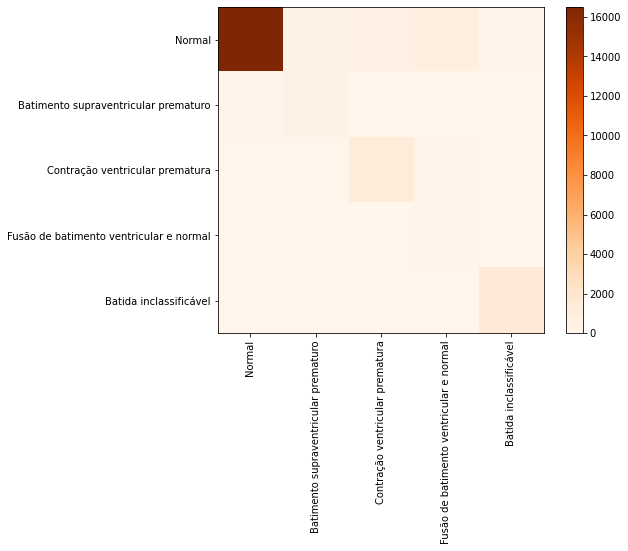

In [ ]:
cm = confusion_matrix(y_true= out_test_mit, y_pred=conv1d_pred_mit, labels=list(MIT_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome], rotation=90)
plt.yticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome])
plt.show()

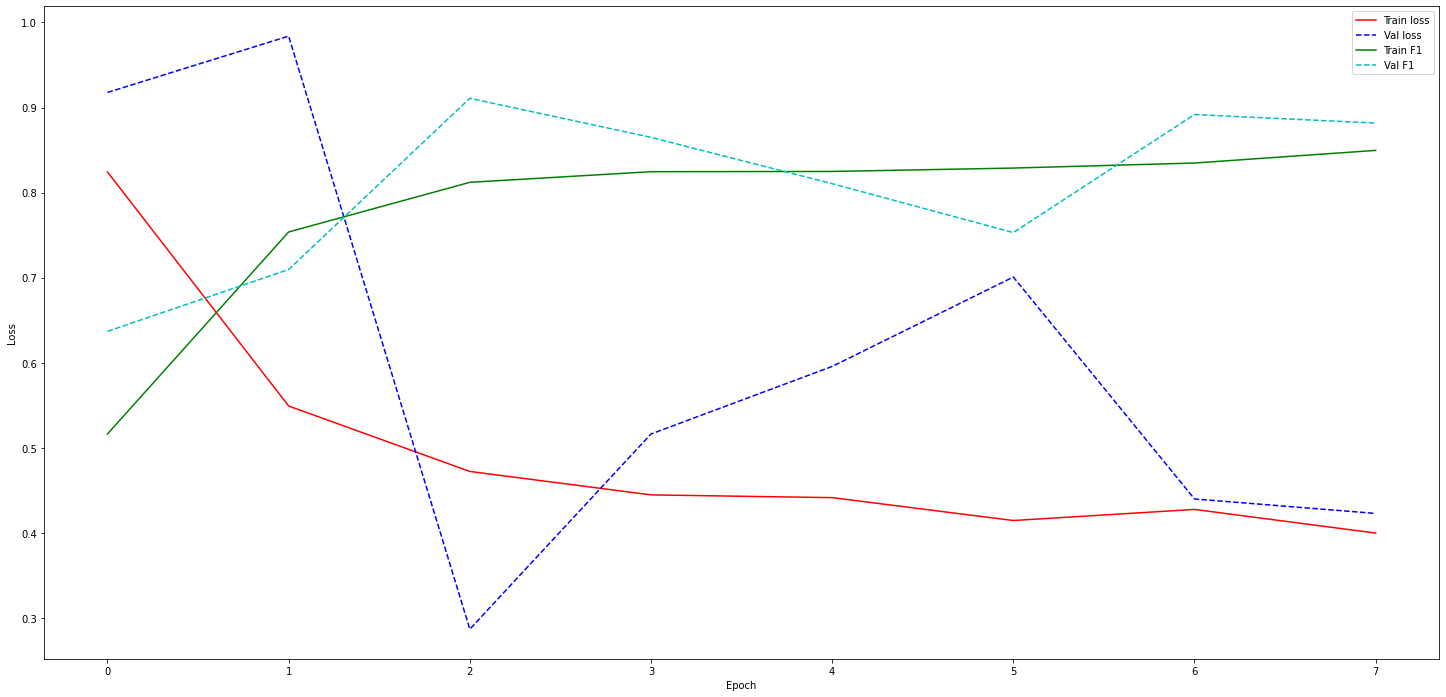

In [ ]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def build_conv1d_res_model_mit (input_shape=(x_train_mit.shape[1],1)):
    model = keras.models.Sequential()
    
    input_ = tf.keras.layers.Input (shape=(input_shape))
        
    conv1_1 = Conv1D(64,7, padding='same', input_shape=input_shape) (input_)
    conv1_1 = BatchNormalization() (conv1_1)
    conv1_1 = tf.keras.layers.ReLU() (conv1_1)

    conv1_2 = Conv1D(64,7, padding='same') (conv1_1)
    conv1_2 = BatchNormalization() (conv1_2)
    conv1_2 = tf.keras.layers.ReLU() (conv1_2)
    
    conv1_3 = Conv1D(64,7, padding='same') (conv1_2)
    conv1_3 = BatchNormalization() (conv1_3)
    conv1_3 = tf.keras.layers.ReLU() (conv1_3)

    concat_1 = Concatenate()([conv1_1 , conv1_3 ])
    max_1 = MaxPool1D(5, padding="same") (concat_1)
    
    conv1_4 = Conv1D(128,7, padding='same') (max_1)
    conv1_4 = BatchNormalization() (conv1_4)
    conv1_4 = tf.keras.layers.ReLU() (conv1_4)

    conv1_5 = Conv1D(128,7, padding='same', input_shape=input_shape) (conv1_4)
    conv1_5 = BatchNormalization() (conv1_5)
    conv1_5 = tf.keras.layers.ReLU() (conv1_5)
    
    conv1_6 = Conv1D(128,7, padding='same', input_shape=input_shape) (conv1_5)
    conv1_6 = BatchNormalization() (conv1_6)
    conv1_6 = tf.keras.layers.ReLU() (conv1_6)

    concat_2 = Concatenate()([conv1_4, conv1_6])
    max_2 = MaxPool1D(5, padding="same") (concat_2)
    
    conv1_7 = Conv1D(256,7, padding='same') (max_2)
    conv1_7 = BatchNormalization() (conv1_7)
    conv1_7 = tf.keras.layers.ReLU() (conv1_7)

    conv1_8 = Conv1D(256,7, padding='same') (conv1_7)
    conv1_8 = BatchNormalization() (conv1_8)
    conv1_8 = tf.keras.layers.ReLU() (conv1_8)

    conv1_9 = Conv1D(256,7, padding='same') (conv1_8)
    conv1_9 = BatchNormalization() (conv1_9)
    conv1_9 = tf.keras.layers.ReLU() (conv1_9)

    concat_3 = Concatenate()([conv1_7, conv1_9])
    max_3 = MaxPool1D(5, padding="same") (concat_3)

    flat = Flatten() (max_3)
    dense_1 = Dense(512, activation='relu') (flat)
    drop_1 = Dropout(0.5) (dense_1)
    dense_2 = Dense(256, activation='relu') (drop_1)
    drop_2 = Dropout(0.5) (dense_2)
    dense_3 = Dense(128, activation='relu') (drop_2)
    dense_4 = Dense(64, activation='relu') (dense_3)
    dense_5 = Dense(32, activation='relu') (dense_4)
    dense_6 = Dense(5, activation="softmax") (dense_5)
        
    model = Model (inputs=input_ , outputs=dense_6)
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("conv1d_mit.h5", save_best_only=True)

earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

model_conv1d_mit= build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], x_train_mit.shape[2]))
model_conv1d_mit.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 187, 32)           256       
                                                                 
 batch_normalization_5 (Batc  (None, 187, 32)          128       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 187, 32)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 38, 32)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_6 (Batc  (None, 38, 64)          

In [ ]:
history_conv1d_mit = model_conv1d_mit.fit(x_train_mit, y_train_mit, epochs=40, batch_size=32, 
                             class_weight=class_weight_mit, validation_data=(x_valid_mit, y_valid_mit),  
                             callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/40
2189/2189 [==============================] - 271s 123ms/step - loss: 0.8299 - f1_score: 0.5314 - val_loss: 0.6384 - val_f1_score: 0.8122
Epoch 2/40
2189/2189 [==============================] - 264s 121ms/step - loss: 0.5814 - f1_score: 0.7662 - val_loss: 0.7265 - val_f1_score: 0.8143
Epoch 3/40
2189/2189 [==============================] - 265s 121ms/step - loss: 0.5116 - f1_score: 0.8288 - val_loss: 0.3593 - val_f1_score: 0.9002
Epoch 4/40
2189/2189 [==============================] - 263s 120ms/step - loss: 0.4500 - f1_score: 0.8415 - val_loss: 0.4767 - val_f1_score: 0.8688
Epoch 5/40
2189/2189 [==============================] - 263s 120ms/step - loss: 0.4494 - f1_score: 0.8432 - val_loss: 0.4728 - val_f1_score: 0.8597
Epoch 6/40
2189/2189 [==============================] - 263s 120ms/step - loss: 0.4223 - f1_score: 0.8337 - val_loss: 0.5508 - val_f1_score: 0.8086
Epoch 7/40
2189/2189 [==============================] - 264s 121ms/step - loss: 0.3618 - f1_score: 0.8582 - val_

In [ ]:
model_conv1d_mit.load_weights("conv1d_mit.h5")
model_conv1d_mit.evaluate(x_test_mit, y_test_mit)
conv1d_pred_mit_proba = model_conv1d_mit.predict (x_test_mit)
conv1d_pred_mit = np.argmax(conv1d_pred_mit_proba,axis=1)

685/685 [==============================] - 6s 9ms/step - loss: 0.3788 - f1_score: 0.8925


In [ ]:
print(classification_report(out_test_mit, conv1d_pred_mit, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

                                         precision    recall  f1-score   support

                                 Normal       0.98      0.89      0.94     18118
   Batimento supraventricular prematuro       0.47      0.64      0.54       556
        Contração ventricular prematura       0.69      0.93      0.79      1448
Fusão de batimento ventricular e normal       0.13      0.93      0.23       162
                 Batida inclassificável       0.95      0.95      0.95      1608

                               accuracy                           0.89     21892
                              macro avg       0.65      0.87      0.69     21892
                           weighted avg       0.94      0.89      0.91     21892



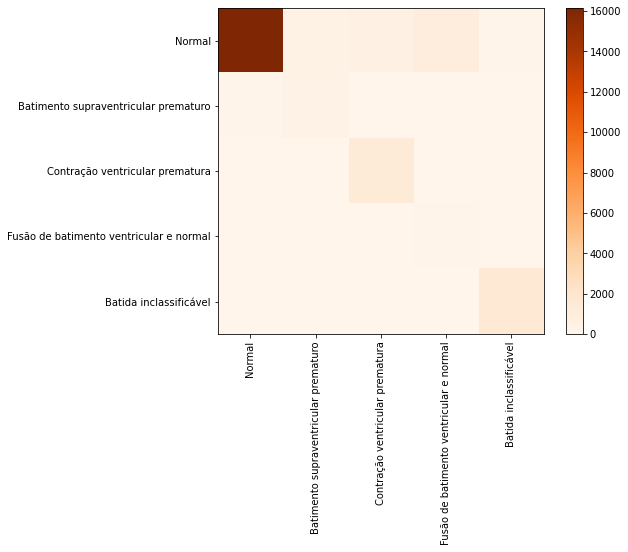

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_true= out_test_mit, y_pred=conv1d_pred_mit, labels=list(MIT_Outcome.keys()))
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Oranges")
plt.colorbar()
plt.xticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome], rotation=90)
plt.yticks(list(MIT_Outcome.keys()),[MIT_Outcome[i] for i in MIT_Outcome])
plt.show()

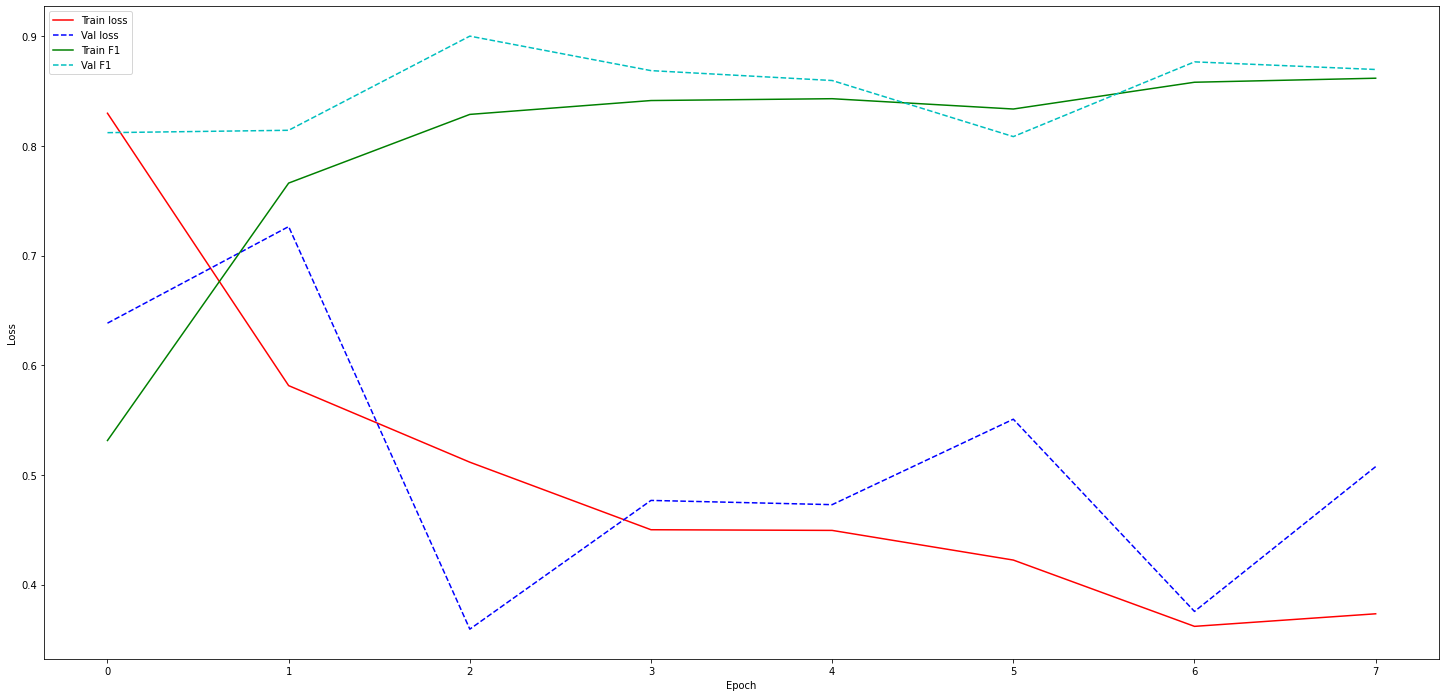

In [ ]:
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

[[17  0  0]
 [ 0 13  1]
 [ 0  0 19]]


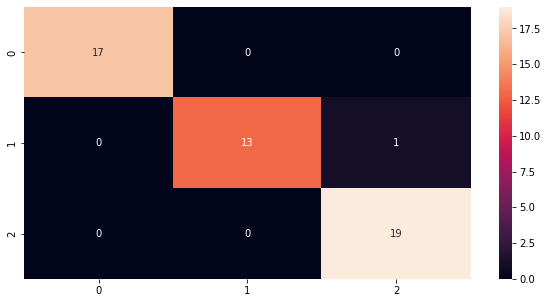